$\newcommand{\ket}[1]{\left|#1\right>}$

$\newcommand{\bra}[1]{\left<#1\right|}$

$\newcommand{\braket}[2]{\left<#1 | #2\right>}$

# The Max Cut Problem

#### References
Qiskit tutorial: https://qiskit.org/textbook/ch-applications/qaoa.html <br>
Wikipedia: https://en.wikipedia.org/wiki/Maximum_cut


## Problem Definition

Let's consider a non-directed graph with $n$ vertices and $m$ edges.

The Max Cut problems aim to find the two complementary subsets of vertices such that the number of edges connecting vertices of different subsets is maximal.

This can be more easily visualized through an example, so that we can consider a graph G(V,E) with:
- n = 5 vertices: $V = \{V_1, V_2, V_3, V_4, V_5\}$;
- m = 6 edges: $E = \{(0,1),(0,2),(1,2),(3,2),(3,4),(4,2)\}$;
- as we can see below, the graph is organized so that it recalls the shape of a butterfly.

We can use a small piece of code to formalize the graph and show it.

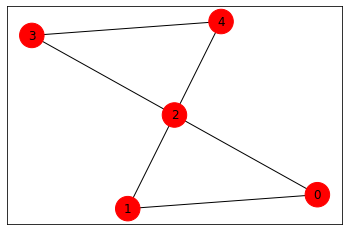

In [1]:
# Tools to handle general graphs
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt 

# Graph parameters 
n = 5
V = np.arange(0,n,1)
E = [(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

# Generating the butterfly graph with 5 nodes
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Plot the graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

This is clearly a combinatorial optimization problem, since in principle we should try all the possible compositions of subsets and count the number of edges connecting vertices of different subsets.

We can formalize our problem as a quadratic unconstrained binary optimization problem (QUBO), if we define the two subsets as $V1$ and $V2$ so that:
- the vertices in $V1$ get are assigned a value 0: $x_i = 0 ~\forall~ V_i \in V1$;
- the vertices in $V2$ get are assigned a value 0: $x_i = 1 ~\forall~ V_i \in V2$.

Additionally, we introduce a weight matrix $w_{ij}$ with:
- $w_{ii} = 0$ (a vertex is never connected to itself);
- $w_{ij} = 1$ for existing edges;
- $w_{ij} = 0$ for if vertex $V_i$ and vertex $V_j$ are not connected by any edge;
- $w_{ij} = w_{ji}$.

Thanks to this, we can defined a cost function that we would like to maximize:

$$ C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1 - x_j)$$

where we can see that if two vertices belong to the same subset, the contribution to the cost function is 0 (at least one of the two terms $x_i$ or $(1 - x_j)$ is 0), while for vertices belonging to complementary subsets, the contribution is 1. The fact that $x_i$ must be 1 and $x_j$ must be 0, avoids counting twice the same edge.

A more general approach may introduce different weights for different edges, so that $w_{ij} \neq 1$, but always keeping $w_{ij} > 0$.

## Problem Resolution: Brute Force Approach

Independently on the values of the weights, the problem is $NP$, since testing all the possible combinations of subsets $V1$ and $V2$ requires $2^n - 2$ (all the element in $V1$ or all the element in $V2$ are not valid solutions) evaluations of the cost function.
This approach is called *brute force* and is strongly inefficient, so that it cannot be used even for not-so-large values of n.

We can try and implement such approach in this case and use the results as a cross-check to test alternative ways of solving the problem.

In particular, in order to have just one possible solution, we are going to give all the edges weight 1, but the edges connecting to vertes $V_2$, which will have weight 2.

case = [0, 0, 0, 0, 0] score = 0
case = [1, 0, 0, 0, 0] score = 3
case = [0, 1, 0, 0, 0] score = 3
case = [1, 1, 0, 0, 0] score = 4
case = [0, 0, 1, 0, 0] score = 8
case = [1, 0, 1, 0, 0] score = 7
case = [0, 1, 1, 0, 0] score = 7
case = [1, 1, 1, 0, 0] score = 4
case = [0, 0, 0, 1, 0] score = 3
case = [1, 0, 0, 1, 0] score = 6
case = [0, 1, 0, 1, 0] score = 6
case = [1, 1, 0, 1, 0] score = 7
case = [0, 0, 1, 1, 0] score = 7
case = [1, 0, 1, 1, 0] score = 6
case = [0, 1, 1, 1, 0] score = 6
case = [1, 1, 1, 1, 0] score = 3
case = [0, 0, 0, 0, 1] score = 3
case = [1, 0, 0, 0, 1] score = 6
case = [0, 1, 0, 0, 1] score = 6
case = [1, 1, 0, 0, 1] score = 7
case = [0, 0, 1, 0, 1] score = 7
case = [1, 0, 1, 0, 1] score = 6
case = [0, 1, 1, 0, 1] score = 6
case = [1, 1, 1, 0, 1] score = 3
case = [0, 0, 0, 1, 1] score = 4
case = [1, 0, 0, 1, 1] score = 7
case = [0, 1, 0, 1, 1] score = 7
case = [1, 1, 0, 1, 1] score = 8
case = [0, 0, 1, 1, 1] score = 4
case = [1, 0, 1, 1, 1] score = 3
case = [0,

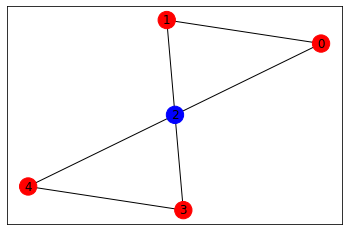

In [2]:
import numpy as np
import networkx as nx

# number of characters
n = 5

# W matrix definition
W = np.array([[0, 1, 2, 0, 0],
              [1, 0, 2, 0, 0],
              [2, 2, 0, 2, 2],
              [0, 0, 2, 0, 1],
              [0, 0, 2, 1, 0]])

best_cost_brute = 0

# computing all possible combinations
for b in range(2**n):
    # x stores all the 2^n possible combinations of 0 and 1
    # for a vector of length n 
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]

    # initialize cost function value
    cost = 0
    # scan all possible costs and keep the highest one
    # (now we want to maximize our score!)
    for i in range(n):
        for j in range(n):
            cost = cost + W[i,j]*x[i]*(1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' score = ' + str(cost))

# Showing results    
colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute)) 

As expected by the way we constructed the problem, the highest score is obtained when $V_2$ is alone in one of the two subsets of $V$.

## Problem Resolution: Ising Hamiltonian

If we want to try and solve the problem more efficiently using a quantum computer, the first step consists in transforming it from a QUBO problem to a Ising Hamiltonian. To get the solution of the problem, we will have to find the fundamental state of the Hamiltonian.

The result is the same, but this new formalism better adapts to the dual state that a qbit can assume:

$\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$

where $\alpha$ and $\beta$ are complex coefficients that satisfy the relation:

$ |\alpha|^2 + |\beta|^2 = 1 $


To do so, we have to perform some transformations to the original formulation of the problem:
- $x_i \rightarrow 
    \dfrac{1}{2}
    (\mathbb{1} + \sigma_z)_i = 
    \dfrac{1}{2}
    \left[
    \mathbb{1} + 
    \begin{bmatrix}
    1 &  0 \\
    0 & -1
    \end{bmatrix}
    \right]_i = 
    \begin{bmatrix}
    1 & 0 \\
    0 & 0
    \end{bmatrix}_i
    $<br>
    where the operator acts only on the corresponding states and has the following properties:
    - $ \begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix} = 
        1 \cdot
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix}$ <br>
        $\begin{bmatrix}
        1 \\
        0
        \end{bmatrix}$ is eigenvector of 
        $\begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}$
        with eigenvalue 1. <br>
        This means that $x_i = 1 \rightarrow         
        \begin{bmatrix}
        1 \\
        0
        \end{bmatrix} = \ket{1}$
    - $ \begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix} = 
        0 \cdot
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix}$ <br>
        $\begin{bmatrix}
        0 \\
        1
        \end{bmatrix}$ is eigenvector of 
        $\begin{bmatrix}
        1 & 0 \\
        0 & 0
        \end{bmatrix}$
        with eigenvalue 0. <br>
        This means that $x_i = 0 \rightarrow         
        \begin{bmatrix}
        0 \\
        1
        \end{bmatrix} = \ket{0}$

- consequently, we will replace:
$(1 - x_i) \rightarrow 
    \left[
    \mathbb{1} -     
    \begin{bmatrix}
    1 & 0 \\
    0 & 0
    \end{bmatrix}
    \right]_i = 
    \begin{bmatrix}
    0 & 0 \\
    0 & 1
    \end{bmatrix}_i$

- for every entry of the original $n x n$ QUBO matrix, take the entry $(i,j)$ and multiply it by the tensor product from $0$ to $n-1$ of $2 x 2$ identities, with the excpetion of the $i$-th and $j$-th terms of the product, which are the $2 x 2$ matrices corresponding to $x_i$ and $(1 - x_j)$. The sum of all these products is a diagonal $2^n x 2^n$ matrix, whose entries are the expectation values obtained with the *brute force* algorithm and corresponds to the Ising Hamiltonian associated to the problem. 

Since the process of converting a QUBO problem is not straightforward, let's make it clearer by doing it for the current problem, using a simple function.

In [6]:
# Define the 2x2 matrices we need

# (1 + pauli_z)/2
sigma_z = np.array([[1, 0], [0, 0]])

# (1 - sigma_z)
minus_z = np.array([[0, 0], [0, 1]])

# Identity
id_matrix = np.array([[1, 0], [0, 1]])

In [4]:
# The actual function
def qubo_to_ising(input_Q):
    n = len(input_Q)
    print("input:")
    print(input_Q)
    print("")
    
    # initialize H
    H = 0

    # compute the contribution of the i,j term to the Hamiltonian
    # i = left-side term = x_i (corresponds to sigma_z)
    for i in range(n):
        # j = right-side term = (1 - x_j) (corresponds to minus_z)
        for j in range(n):            
            # first term
            matrix_ij = 0
            if i == 0:
                matrix_ij = sigma_z
            elif j == 0:
                matrix_ij = minus_z
            else:
                matrix_ij = id_matrix
            
            # tensor product n times
            for k in range(1,n):
                if i == k:
                    new_term = sigma_z
                elif j == k:
                    new_term = minus_z
                else:
                    new_term = id_matrix                
                matrix_ij = np.kron(matrix_ij, new_term)

            # multiply by the i,j term of input_Q 
            matrix_ij = matrix_ij * input_Q[i,j]
            
            # sum
            H = H + matrix_ij
    
    return(-H) 

In [7]:
# Translate our QUBO matrix to a Ising Hamiltonian
H = qubo_to_ising(W)

print('Ising Hamiltonian dimensions:' + str(H.shape))
print("")

# Check eigenvalues
print("Ising eigenvalues:")
eigenvalues = []
for i in range(len(H)):
    eigenvalues.append(H[i,i])
print(eigenvalues)    

input:
[[0 1 2 0 0]
 [1 0 2 0 0]
 [2 2 0 2 2]
 [0 0 2 0 1]
 [0 0 2 1 0]]

Ising Hamiltonian dimensions:(32, 32)

Ising eigenvalues:
[0, -3, -3, -4, -8, -7, -7, -4, -3, -6, -6, -7, -7, -6, -6, -3, -3, -6, -6, -7, -7, -6, -6, -3, -4, -7, -7, -8, -4, -3, -3, 0]


## Problem Resolution: Variational Quantum Eigensolver
